In [52]:
import os
import shutil
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn import svm, grid_search
from sklearn.neural_network import MLPClassifier
import cv2
from skimage import io
from PIL import Image
import numpy as np
import pandas as pd
import random
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
input_faces_folder = '../data/HvN/faces_full'
input_predict_faces_folder = '../data/face_croped'
out_predict_faces_folder = '../data/face_predicted'
IMG_WIDTH = 100
IMG_HEIGHT = 100
FRACTION = 8/10
N_COMPONENTS = 200
N_HIDEN_LAYERS = 100
N_OUTPUT_LAYERS = 2
MAX_ITER = 1000
TOLERANCE = 1e-3
BATCH_SIZE = 32

In [54]:
def process_file(file_name):
    image = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
    newimage = np.reshape(image, IMG_HEIGHT*IMG_WIDTH)
    label = file_name[-5:][:1]
    return newimage, label

In [55]:
process_file(input_faces_folder+'/1-06-M.jpg')

(array([ 32,  30,  28, ..., 124, 122, 110], dtype=uint8), 'M')

In [56]:
#Process folder
def process_folder(folder_path):
    matrixX=None
    matrixY=None
    matrixX_arr = []
    matrixY_arr = []
    for root, dirs, files in os.walk(folder_path):
        random.shuffle(files, random.random)      
        for file in files:
            if file.endswith('.jpg'):
                file_name = os.path.join(root, file)
                row_arr, label = process_file(file_name)
                matrixX_arr.append(np.array(row_arr))
                matrixY_arr.append(label)
                
    matrixX=np.array(matrixX_arr)
    matrixY=np.array(matrixY_arr)
    return matrixX, matrixY

In [57]:
X,Y = process_folder(input_faces_folder)
X_train = X[:int(X.shape[0]*FRACTION)]
Y_train = Y[:int(Y.shape[0]*FRACTION)]
X_validate = X[int(X.shape[0]*FRACTION):]
Y_validate = Y[int(Y.shape[0]*FRACTION):]

In [58]:
print(X.shape)
print(Y.shape)
print(X_train.shape)
print(Y_train.shape)
print(X_validate.shape)
print(Y_validate.shape)

(927, 10000)
(927,)
(741, 10000)
(741,)
(186, 10000)
(186,)


In [59]:
pca = PCA(n_components=N_COMPONENTS, svd_solver='randomized', whiten=True).fit(X_train)

X_train_pca = pca.transform(X_train)
X_validate_pca = pca.transform(X_validate)

In [60]:
print(X_train_pca.shape)
print(X_validate_pca.shape)

(741, 200)
(186, 200)


In [61]:
def knn(X, X_train, Y_train, k=1):
    inXMat = np.tile(X, (len(Y_train),1))
    deltaXMat = inXMat - X_train
    sqDiffMat = deltaXMat**2
    sqDistances = sqDiffMat.sum(axis=1)
    sqrt = sqDistances**0.5
    sqrtIndex =[]
    for i, v in enumerate(sqrt):
        a = {}
        a['id'] = i
        a['val'] = v
        sqrtIndex.append(a)
    sqrtSort = sorted(sqrtIndex,key= lambda x: x['val'])
    sqrtSortK = sqrtSort[:k]
    for a in sqrtSortK:
        label = Y_train[a['id']]
    return label

In [62]:
def count_accuracy_knn(X_test, Y_test, X_train, Y_train):
    sum =0
    for i, test in enumerate(X_test):
        l = knn(test, X_train, Y_train)
        if l == Y_test[i]:
            sum += 1
    return sum, 100*(sum/len(Y_test))

In [63]:
#Decision Tree
decision_tree = tree.DecisionTreeClassifier(criterion='entropy')
# decision_tree.fit(X_train, Y_train)
decision_tree.fit(X_train_pca, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [64]:
#Logistic
logistic = linear_model.LogisticRegression(max_iter=MAX_ITER, tol=TOLERANCE)
# logistic.fit(X_train, Y_train.ravel())
logistic.fit(X_train_pca, Y_train.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.001,
          verbose=0, warm_start=False)

In [65]:
#Multi layers perception
MLP = MLPClassifier(activation='relu', solver='adam', hidden_layer_sizes=(N_HIDEN_LAYERS, N_OUTPUT_LAYERS), max_iter=MAX_ITER, batch_size=BATCH_SIZE, verbose=True, early_stopping=True).fit(X_train_pca, Y_train)
# MLP.fit(X_train, Y_train.ravel())
MLP.fit(X_train_pca, Y_train.ravel())

Iteration 1, loss = 0.66696793
Validation score: 0.680000
Iteration 2, loss = 0.57191812
Validation score: 0.680000
Iteration 3, loss = 0.51392387
Validation score: 0.693333
Iteration 4, loss = 0.42972915
Validation score: 0.706667
Iteration 5, loss = 0.35255420
Validation score: 0.653333
Iteration 6, loss = 0.29558641
Validation score: 0.693333
Iteration 7, loss = 0.25783056
Validation score: 0.693333
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.80353658
Validation score: 0.653333
Iteration 2, loss = 0.55416829
Validation score: 0.640000
Iteration 3, loss = 0.48746332
Validation score: 0.693333
Iteration 4, loss = 0.43518303
Validation score: 0.773333
Iteration 5, loss = 0.40020658
Validation score: 0.813333
Iteration 6, loss = 0.37082944
Validation score: 0.800000
Iteration 7, loss = 0.35142224
Validation score: 0.773333
Iteration 8, loss = 0.33343761
Validation score: 0.786667
Validation score did not improve mor

MLPClassifier(activation='relu', alpha=0.0001, batch_size=32, beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(100, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=True, warm_start=False)

In [66]:
parameters = {'kernel':('linear', 'rbf'), 'C': [1e3, 5e3]}
SVM = grid_search.GridSearchCV(svm.SVC(), parameters)
SVM.fit(X_train_pca, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ('linear', 'rbf'), 'C': [1000.0, 5000.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [67]:
def show_image(x_array):
    img_arr = np.reshape(x_array, (IMG_HEIGHT, IMG_WIDTH))
    plt.imshow(img_arr, cmap="gray")
    print(img_arr.shape)

(100, 100)


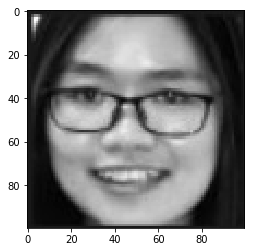

In [68]:
show_image(X_validate[1])

In [69]:
def count_accuracy(estimator, Xdata, Ydata):    
    pred_labels = estimator.predict(Xdata)  
    acc = (metrics.accuracy_score(Ydata, pred_labels))*100
    count = 0
    for i, y in enumerate(Ydata):
        if y == pred_labels[i]:
            count = count + 1
        
    return count, acc

In [70]:
count1, acc1 = count_accuracy(decision_tree, X_validate_pca, Y_validate)
count2, acc2 = count_accuracy(logistic, X_validate_pca, Y_validate)
count3, acc3 = count_accuracy(MLP, X_validate_pca, Y_validate)
count4, acc4 = count_accuracy_knn(X_validate_pca, Y_validate, X_train_pca, Y_train)
count5, acc5 = count_accuracy(SVM, X_validate_pca, Y_validate)

# count1, acc1 = count_accuracy(decision_tree, X_validate, Y_validate)
# count2, acc2 = count_accuracy(logistic, X_validate, Y_validate)
# count3, acc3 = count_accuracy(MLP, X_validate, Y_validate)
# count4, acc4 = count_accuracy_knn(X_validate, Y_validate, X_train, Y_train)
# count5, acc5 = count_accuracy(SVM, X_validate_pca, Y_validate)

In [71]:
print('Decision Tree: {0} - acuracy: {1}'.format(count1, acc1))
print('Logistic: {0} - acuracy: {1}'.format(count2, acc2))
print('Multi layers perception: {0} - acuracy: {1}'.format(count3, acc3))
print('K-NN: {0} - acuracy: {1}'.format(count4, acc4))
print('SVM: {0} - acuracy: {1}'.format(count5, acc5))

Decision Tree: 151 - acuracy: 81.18279569892472
Logistic: 153 - acuracy: 82.25806451612904
Multi layers perception: 151 - acuracy: 81.18279569892472
K-NN: 139 - acuracy: 74.73118279569893
SVM: 158 - acuracy: 84.94623655913979


In [72]:
MLs = []
MLs.append({'name': 'Decision tree', 'sum':count1, 'acc':acc1})
MLs.append({'name': 'Logistic', 'sum':count2, 'acc':acc2})
MLs.append({'name': 'Multi layers perception', 'sum':count3, 'acc':acc3})
MLs.append({'name': 'K-NN', 'sum':count4, 'acc':acc4})
MLs.append({'name': 'SVM', 'sum':count5, 'acc':acc5})

Text(0,0.5,'Algorithm')

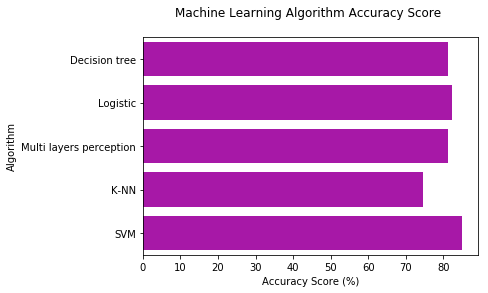

In [73]:
#Bar plot ML algorithms:
ML_columns = ['Name', 'Sum Correct', 'Accuracy']
ML_compare = pd.DataFrame(columns = ML_columns)

row_index = 0
for alg in MLs:
    ML_compare.loc[row_index, 'Name'] = alg['name']
    ML_compare.loc[row_index, 'Sum Correct'] = alg['sum']
    ML_compare.loc[row_index, 'Accuracy'] = alg['acc']    
    row_index+=1

sns.barplot(x='Accuracy', y = 'Name', data = ML_compare, color = 'm')

plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')